# Hierarchical Clustering

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

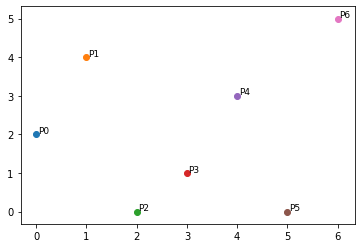

In [11]:
x2 = np.array([2, 4, 0, 1, 3, 0, 5])
x1 = np.array(list(range(len(x2))))
X = np.vstack((x1,x2)).T

labels = ['P{}'.format(i) for i in x1]

for i,(x1i,x2i) in enumerate(zip(x1,x2)):
    plt.scatter(x1i, x2i)
    plt.text(x1i+.03, x2i+.03, labels[i], fontsize=9)
plt.show()

#### Using Euclidean Distances

In [12]:
Z_ = linkage(pdist(X), metric='euclidean', method='average')
pd.DataFrame(Z_, columns=['P1','P2','Distance','Points in Cluster'])

,P1,P2,Distance,Points in Cluster
0,2.0,3.0,1.414214,2.0
1,0.0,1.0,2.236068,2.0
2,5.0,7.0,2.618034,3.0
3,4.0,6.0,2.828427,2.0
4,8.0,9.0,4.126897,5.0
5,10.0,11.0,4.459865,7.0


#### Using Cosine Distances

In [13]:
distances = pdist(X,metric='cosine') # Returns the upper half matrix of the cosine distances matrix  
Z = linkage(y=distances, method='ward')
pd.DataFrame(Z, columns=['P1','P2','Distance','Points in Cluster'])

,P1,P2,Distance,Points in Cluster
0,2.0,5.0,0.000000,2.0
1,4.0,6.0,0.001312,2.0
2,0.0,1.0,0.029857,2.0
3,3.0,7.0,0.059255,3.0
4,8.0,10.0,0.276615,5.0
5,9.0,11.0,1.085484,7.0


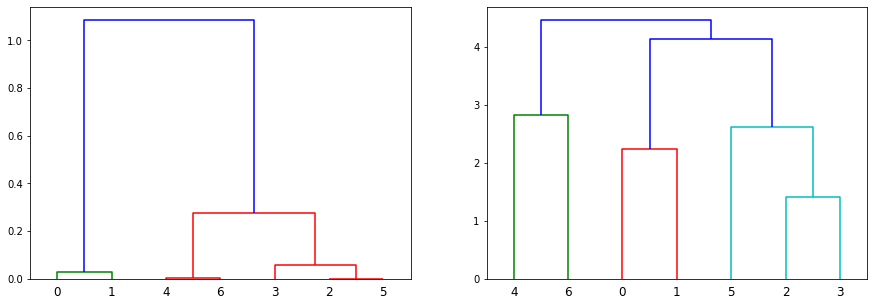

In [14]:
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
_ = dendrogram(Z, ax=ax1)
_ = dendrogram(Z_, ax=ax2)

In [20]:
cluster_dict = defaultdict(list)
clusters = fcluster(Z, 3, criterion='maxclust')

for i, c in enumerate(clusters):
    cluster_dict[c].append(i)
print(cluster_dict)

defaultdict(<class 'list'>, {1: [0, 1], 3: [2, 3, 5], 2: [4, 6]})


### Retrieve Cluster ID of each document

#### Assuming we know k --> Alternatives using distances etc

In [71]:
cluster_idx = fcluster(Z, 3, criterion='maxclust')

In [72]:
def retrieve_docs(cluster_idx, idx):
    ''' Return the indexes of the documents that match the cluster id '''
    doc_ids = np.array(list(range(len(cluster_idx))))
    mask = cluster_idx==idx
    return [c for c,i in zip(doc_ids,mask) if i]

In [73]:
docs = np.array(list(range(len(Z))))
docs

array([0, 1, 2, 3, 4, 5])

In [74]:
cluster_idx

array([1, 1, 3, 3, 2, 3, 2], dtype=int32)

In [75]:
retrieve_docs(cluster_idx,idx=3)

[2, 3, 5]

In [78]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 5
cluster_dict = defaultdict(lambda: defaultdict(list))
for level in range(MIN_CLUSTERS,MAX_CLUSTERS):
    cluster_idx = fcluster(Z, level, criterion='maxclust')
    for c in range(level+1):
        cluster_dict[level][c].append(retrieve_docs(cluster_idx,c))

In [79]:
cluster_dict

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(list,
                         {0: [[]], 1: [[0, 1]], 2: [[2, 3, 4, 5, 6]]}),
             3: defaultdict(list,
                         {0: [[]], 1: [[0, 1]], 2: [[4, 6]], 3: [[2, 3, 5]]}),
             4: defaultdict(list,
                         {0: [[]],
                          1: [[0, 1]],
                          2: [[4, 6]],
                          3: [[2, 5]],
                          4: [[3]]})})

## Pipeline until TFIDF

In [24]:
import numpy
import pandas
numpy.set_printoptions(precision=3)
pandas.options.display.float_format = '{:,.2f}'.format

In [25]:
import os
import pickle
from pprint import pprint
from os.path import join as JP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

catalog = Catalog()
catalog = load_catalog(path=paths['catalog'], name='spacy_pipeline_on_US_corpus')
catalog.documents = catalog.documents[:6]
print('Total documents = ', len(catalog.documents))
corpus = catalog.collect_corpus(attr='processed_text', form=list)

EMBED_SIZE = 10000        
NUM_CLUSTERS = 4
WORDS_PER_CLUSTER = 50

vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

Total documents =  6
(6, 10000)


,0000,0021,0023,0069,0076,14,14 composition,14 composition liquid,15,2h,...,yield methyl,yield methyl trimethylcyclohexylcarbamic,yield product,yield product obtain,yield reaction,yield reaction temperature,yield structural,yield structural assignment,zeolite,zinc
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,...,0.00,0.00,0.02,0.01,0.00,0.00,0.05,0.05,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [26]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Hierarchical Clustering

### Similarity Matrix

In [27]:
from scripts.algorithms.clustering import (
    hca_document_clustering, plot_dendogram_from_linkage_matrix)

In [31]:
dists = pdist(tfidf.representation, metric='cosine')
Z = hca_document_clustering(dists, method='ward')
Z

AttributeError: 'numpy.ndarray' object has no attribute 'representation'

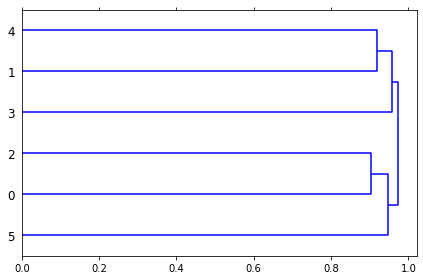

In [29]:
plot_dendogram_from_linkage_matrix(
    dist, truncate_mode='lastp', p=6, 
    show_leaf_counts=True, leaf_rotation=0.)